In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.tree import plot_tree

In [2]:
# Generate dataset

X, y = make_classification(n_samples=1000, n_features=10, 
                           n_informative=5, n_redundant=2,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

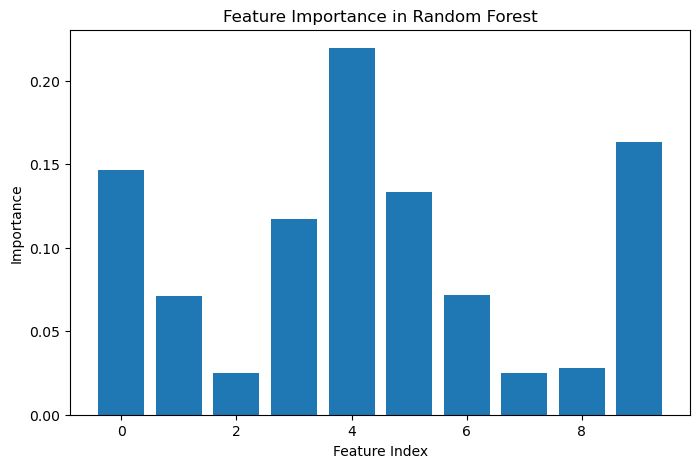

In [3]:
# 1. Feature Importance

"""
Purpose: Identify which features contribute most to predictions.
Why use it: To interpret the model and perform feature selection.
When to use: After training the Random Forest.
X-axis: Feature index (or name).
Y-axis: Importance score (Gini Importance).
Intuition: Higher values → feature is more influential.
"""
importances = rf.feature_importances_
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


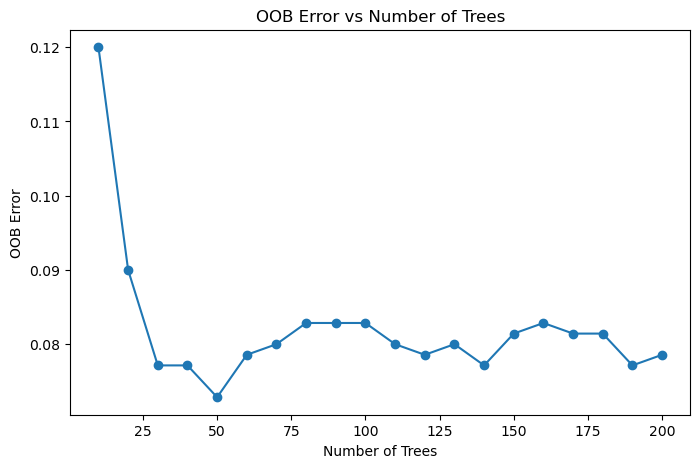

In [4]:
# 2. OOB Error vs Number of Trees

"""
Purpose: Show how error decreases as number of trees increases.
Why use it: To decide a good value of n_estimators.
When to use: While tuning Random Forest.
X-axis: Number of trees.
Y-axis: OOB Error.
Intuition: Error decreases and stabilizes → adding more trees doesn’t help much.
"""
oob_errors = []
tree_range = range(10, 201, 10)
for n in tree_range:
    model = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    model.fit(X_train, y_train)
    oob_errors.append(1 - model.oob_score_)

plt.figure(figsize=(8,5))
plt.plot(tree_range, oob_errors, marker="o")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error")
plt.title("OOB Error vs Number of Trees")
plt.show()

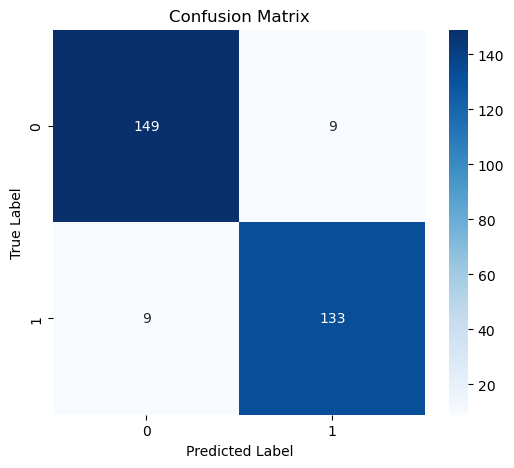

In [5]:
# 3. Confusion Matrix

"""
Purpose: Show classification performance in terms of correct/incorrect predictions.
Why use it: To evaluate classifier performance.
When to use: After predictions.
X-axis: Predicted label.
Y-axis: True label.
Intuition: Diagonal = correct predictions, Off-diagonal = errors.
"""
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


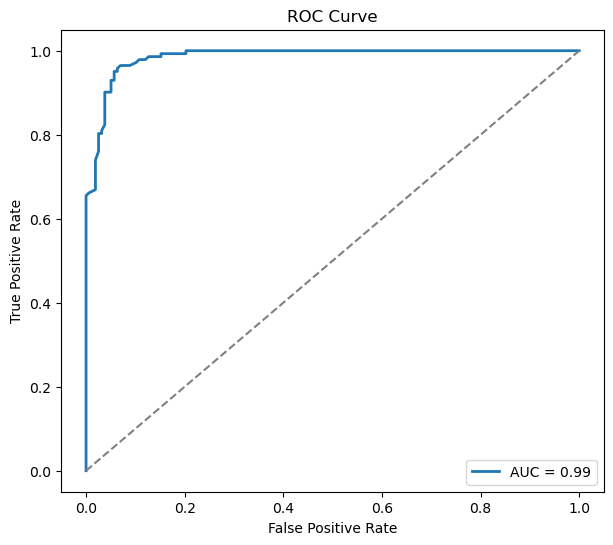

In [6]:
# 4. ROC Curve

"""
Purpose: Show trade-off between sensitivity (TPR) and false alarm rate (FPR).
Why use it: Evaluate classifier performance for different thresholds.
When to use: With binary classification.
X-axis: False Positive Rate.
Y-axis: True Positive Rate.
Intuition: Closer curve is to top-left → better classifier. AUC measures overall quality.
"""
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

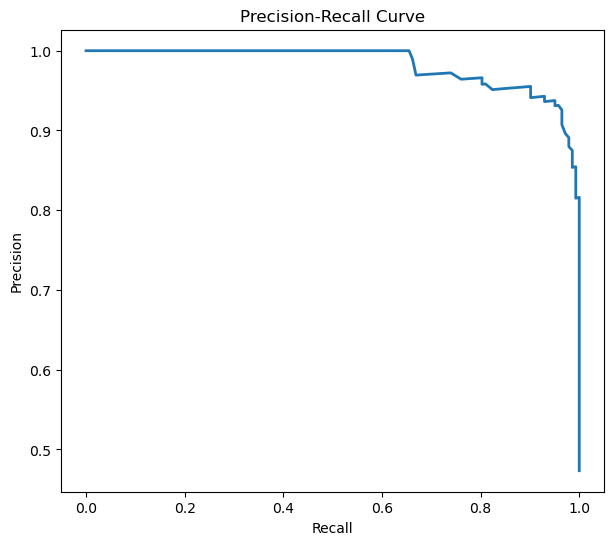

In [7]:
# 5. Precision-Recall Curve

"""
Purpose: Show balance between precision and recall.
Why use it: Especially useful for imbalanced datasets.
When to use: Classification with skewed class distribution.
X-axis: Recall.
Y-axis: Precision.
Intuition: Higher curve = better. Trade-off between catching positives vs false alarms.
"""
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

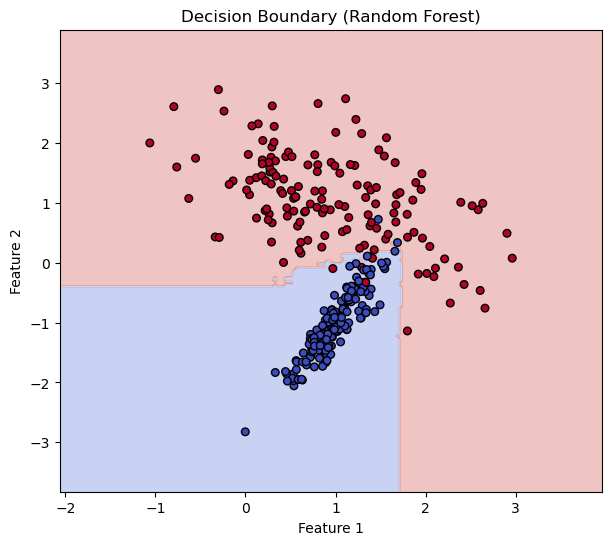

In [8]:
# 6. Decision Boundary (only for 2D dataset)

"""
Purpose: Visualize how Random Forest separates classes.
Why use it: To understand decision regions.
When to use: With 2D feature datasets.
X-axis, Y-axis: Feature 1 and Feature 2.
Intuition: Forest creates smooth, aggregated boundaries vs jagged single tree.
"""
X2, y2 = make_classification(n_samples=300, n_features=2, n_redundant=0,
                             n_informative=2, n_clusters_per_class=1,
                             random_state=42)

rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X2, y2)

xx, yy = np.meshgrid(np.linspace(X2[:,0].min()-1, X2[:,0].max()+1, 200),
                     np.linspace(X2[:,1].min()-1, X2[:,1].max()+1, 200))
Z = rf2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X2[:,0], X2[:,1], c=y2, s=30, cmap="coolwarm", edgecolor="k")
plt.title("Decision Boundary (Random Forest)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

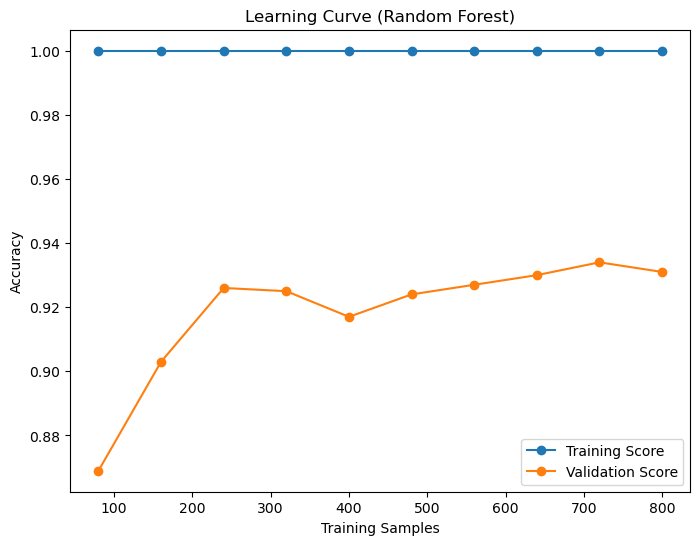

In [9]:
# 7. Learning Curve

"""
Purpose: Show how performance changes with more training data.
Why use it: Diagnose bias-variance trade-off.
When to use: Model evaluation.
X-axis: Number of training samples.
Y-axis: Accuracy.
Intuition: Training and validation curves converge → good generalization.
"""
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', label="Validation Score")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.show()

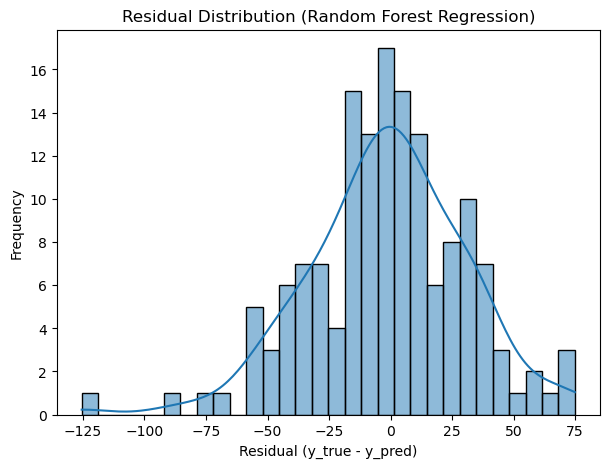

In [10]:
# 8. Error Distribution (Regression Demo)

"""
Purpose: Show distribution of residuals (errors).
Why use it: Evaluate regression model.
When to use: Regression tasks.
X-axis: Residual value (y_true - y_pred).
Y-axis: Frequency.
Intuition: Should be centered at 0. Wider spread = higher error.
"""
X_reg, y_reg = make_regression(n_samples=500, n_features=5, noise=10, random_state=42)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(Xr_train, yr_train)
residuals = yr_test - rf_reg.predict(Xr_test)

plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution (Random Forest Regression)")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

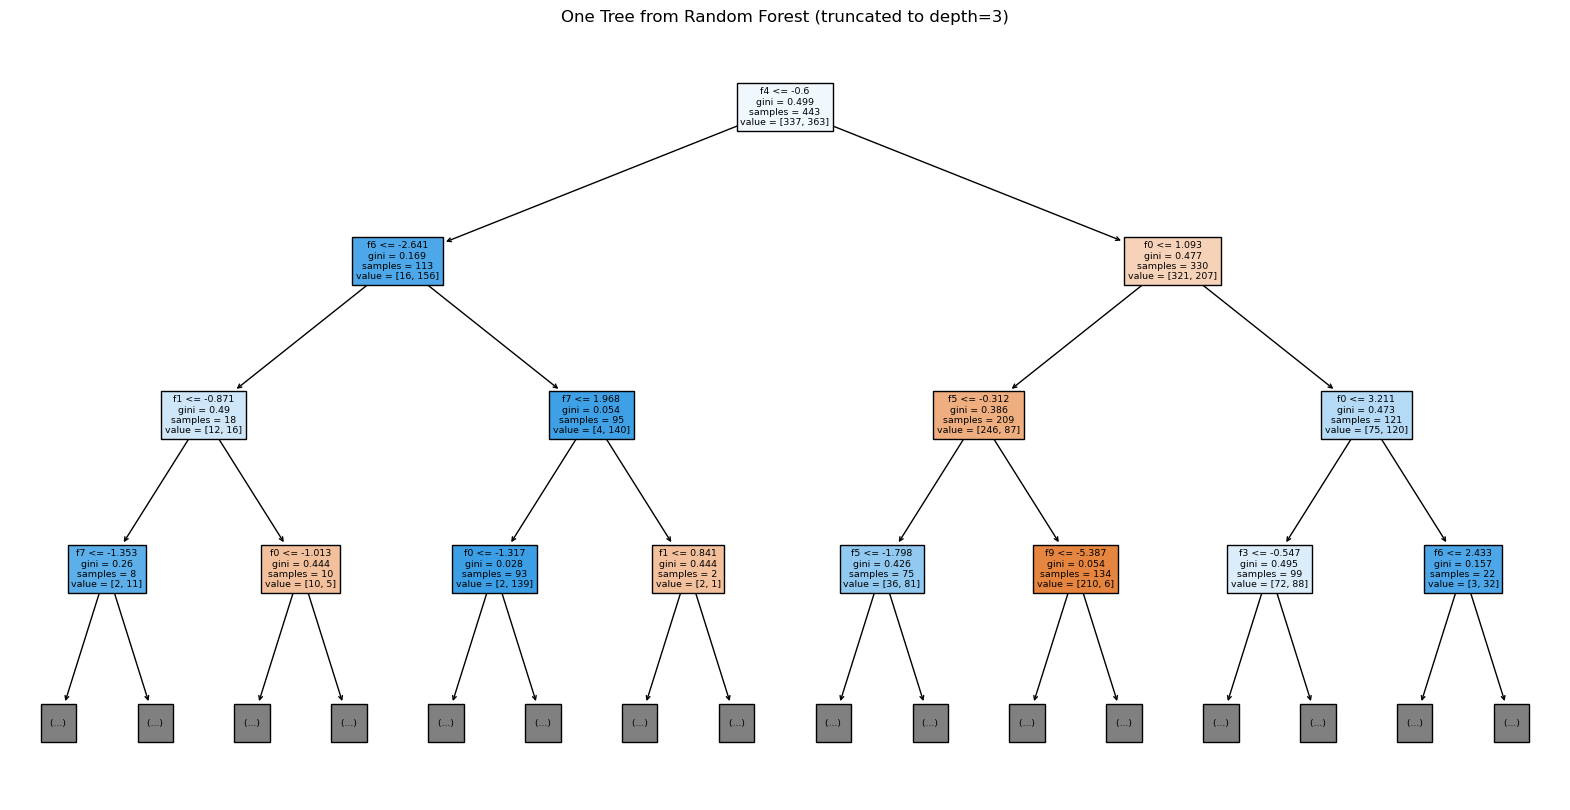

In [11]:
# 9. Visualizing a Single Tree inside Random Forest

"""
Purpose: Look at structure of one decision tree in the forest.
Why use it: Interpretability of what one tree learned.
When to use: Debugging / educational purposes.
X-axis, Y-axis: Tree nodes (splits).
Intuition: Shows rules learned by one tree (but forest = many such trees).
"""
plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, feature_names=[f"f{i}" for i in range(X.shape[1])], max_depth=3)
plt.title("One Tree from Random Forest (truncated to depth=3)")
plt.show()